# COCO implementation test

This notebook is an implementation of the constrained covariance from [Kernel Constrained Covariance for Dependence Measurement, A.Gretton et al.,2005](https://proceedings.mlr.press/r5/gretton05a/gretton05a.pdf)

### Generating some random variables

In [2]:
import numpy as np

In [3]:
def X(n:int=None,cov: np.array=np.identity(4),mean: np.array = np.zeros(4))->np.array:
    """
    Args:
        n,int: number of samples by default n=None ie a single sample
        cov,np.array: covariance matrix by default cov=np.identity(3)
        mean: mean value vector by default mean=np.zeros(3)

    Returns:
        n samples of the gaussian vector defined by the cov matrix and mean vector
    """
    
    return np.random.multivariate_normal(mean,cov,n)

In [4]:
print(X())

[-1.35534307  0.92675027  0.95724515  0.5688511 ]


### Implementing COCO

We know from (2.3) in the article that: $$COCO_{emp}(z,F,G)=\frac{1}{n}\sqrt{{\lVert \bar{K}^j\bar{K}^g \rVert}_2}$$

With $\bar{K}^f$ the matrix obtained via the projection $ \bar{K}^f  =  PK^fP$ with the projection operator $ P_{ij} = {\delta}_{ij}  - \frac{1}{n}$ and Gram matrix ${K^{f}}_{ij} =k_f(x_i,x_j)$. $\; \bar{K}^g$ is defined analogously.

In [5]:
def map_projection_op(i:int,j:int,n:int)-> float:
    """This function gives the value of Projector operator matrix coefficients
    Args:
        i : line number
        j : row number
        n : number of samples
    Returns:
        P_ij
    """
    if i==j:
        return 1-1/n
    else:
        return -1/n 
    
def map_kernel_gram(i:int,j:int,x:np.array,k:callable) -> float:
    """This function gives the value of the Gram matrix coefficients
    
    Args:
        i : line number
        j : row number
        x : samples vector
        k : kernel
    Returns:
        K_ij
    """
    return k(x[i],x[j])


def COCO(Kf:callable,Kg:callable,x:np.array,y:np.array)->float:
    """This function computes the constrained covariance for two kernels and some samples
    
    Args:
        Kf : first kernel
        Kg : second kernel
        x : samples from F
        y : samples from G
    Returns:
        COCO_emp
    """
    n= len(x)
    Kf_gram = np.array([list( map_kernel_gram(i,j,x,Kf) for i in range(n)) for j in range(n)])
    Kg_gram = np.array([list( map_kernel_gram(i,j,y,Kg) for i in range(n)) for j in range(n)])
    P = np.array([list( map_projection_op(i,j,n) for i in range(n)) for j in range(n)])
    Kf_bar = np.matmul(P,np.matmul(Kf_gram,P))
    Kg_bar = np.matmul(P,np.matmul(Kg_gram,P))

    return np.sqrt(np.linalg.norm(np.matmul(Kf_bar,Kg_bar),2))/n
    

### Implementing HSIC

In [6]:
def HSIC(k:callable,l:callable,x:np.array,y:np.array):
    """This function computes the Hilbert-Schmidt Independence Criterion for two kernels and some samples
    Args:
        k : first kernel
        l : second kernel
        x : samples from F
        y : samples from G
    Returns:
        HSIC_emp
    """
    m = len(x)
    K = np.array([list( map_kernel_gram(i,j,x,k) for i in range(m)) for j in range(m)])
    L = np.array([list( map_kernel_gram(i,j,y,l) for i in range(m)) for j in range(m)])
    H = np.array([list( map_projection_op(i,j,m) for i in range(m)) for j in range(m)])
    res_mat = np.matmul(K,np.matmul(H,np.matmul(L,H)))

    return np.trace(res_mat)*(m-1)**(-2)

### Test on some Kernels
Here we define some kernels and perform some test using COCO on samples from the variables previously defined

In [73]:

def K_laplacian(x:np.array,y:np.array,factor:float)->float:
    """This function returns the evaluation of the laplacian kernel on x and y
    Args:
        x : random variable vector
        y : random variable vector
    Returns:
        k(x,y)
        
    """
    
    if type(x)==np.ndarray:
        return np.exp(-factor*np.linalg.norm(x-y,1))
    else:
        return np.exp(-factor*(abs(x-y)))

def K_gaussian(x:np.array,y:np.array,factor:float)->float:
    """This function returns the evaluation of the gaussian kernel on x and y
    
    Args:
        x : random variable vector
        y : random variable vector
    Returns:
        k(x,y)
    """
    
    if type(x)==np.ndarray:
        return np.exp(-factor*np.linalg.norm(x-y,2))
    else:
        return np.exp(-factor*((x-y)**2))


In [8]:
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)
x = X(10)
y = X(10)
COCO(Kf,Kg,x,y)

0.11672641540518844

100%|██████████| 36/36 [00:00<00:00, 99.00it/s] 


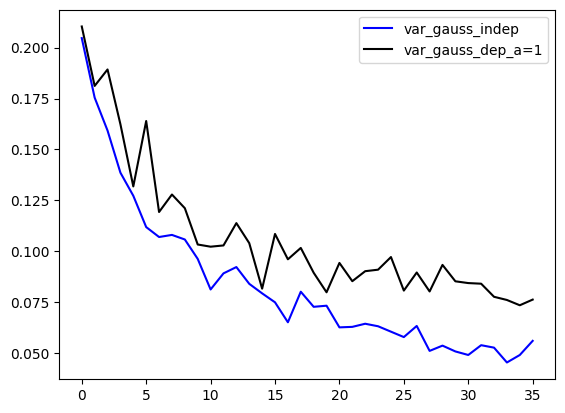

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
m = 40
a= 1
start_point = 5
res_indep = np.empty(m-start_point+1)
res_dep = np.empty(m-start_point+1)
cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0.5,1,0.6,0])

for i in tqdm(range(start_point,m+1)):
    x = X(i,cov,mean)
    y = X(i,cov,mean)
    res_indep[i-start_point] = COCO(Kf,Kg,x,y)
    x2 = X(i,cov,mean)
    y2 = a*x2 +(1-a)*X(i,cov,mean)
    res_dep[i-start_point] = COCO(Kf,Kg,x2,y2)


plt.plot(res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(res_dep,color = "black", label ="var_gauss_dep_a={}".format(a))
plt.legend()
plt.show()


100%|██████████| 16/16 [00:00<00:00, 108.33it/s]


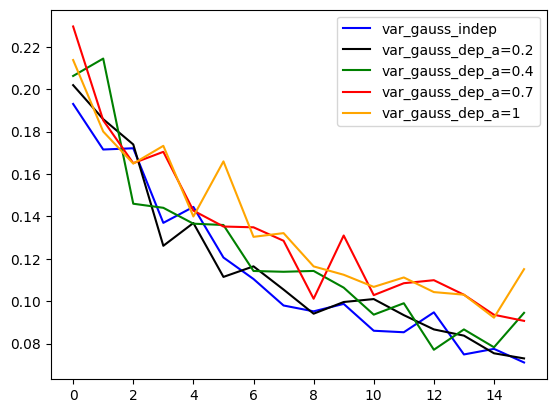

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
m = 20
a= 0.2
a1=0.4
a2 = 0.7
a3 =1
res_indep = np.empty(m-start_point+1)
res_dep = np.empty(m-start_point+1)
res_dep1 = np.empty(m-start_point+1)
res_dep2 = np.empty(m-start_point+1)
res_dep3 = np.empty(m-start_point+1)
cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0.5,1,0.6,0])

for i in tqdm(range(start_point,m+1)):
    x = X(i,cov,mean)
    y = X(i,cov,mean)
    res_indep[i-start_point] = COCO(Kf,Kg,x,y)
    x2 = X(i,cov,mean)
    y2 = a*x2 +(1-a)*X(i,cov,mean)
    res_dep[i-start_point] = COCO(Kf,Kg,x2,y2)
    x3 = X(i,cov,mean)
    y3 = a1*x3 +(1-a1)*X(i,cov,mean)
    res_dep1[i-start_point] = COCO(Kf,Kg,x3,y3)
    x4 = X(i,cov,mean)
    y4 = a2*x4 +(1-a2)*X(i,cov,mean)
    res_dep2[i-start_point] = COCO(Kf,Kg,x4,y4)
    x5 = X(i,cov,mean)
    y5 = a3*x5 +(1-a3)*X(i,cov,mean)
    res_dep3[i-start_point] = COCO(Kf,Kg,x5,y5)


plt.plot(res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(res_dep,color = "black", label ="var_gauss_dep_a={}".format(a))
plt.plot(res_dep1,color = "green", label ="var_gauss_dep_a={}".format(a1))
plt.plot(res_dep2,color = "red", label ="var_gauss_dep_a={}".format(a2))
plt.plot(res_dep3,color = "orange", label ="var_gauss_dep_a={}".format(a3))
plt.legend()
plt.show()


100%|██████████| 16/16 [00:00<00:00, 102.09it/s]


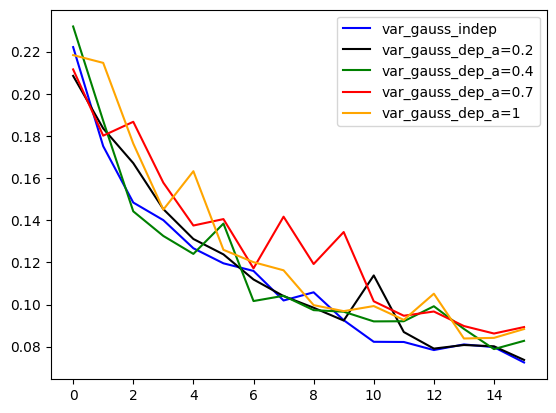

In [11]:
m = 20
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_laplacian(x,y,factor)

import matplotlib.pyplot as plt
from tqdm import tqdm
a= 0.2
a1=0.4
a2 = 0.7
a3 =1
res_indep = np.empty(m-start_point+1)
res_dep = np.empty(m-start_point+1)
res_dep1 = np.empty(m-start_point+1)
res_dep2 = np.empty(m-start_point+1)
res_dep3 = np.empty(m-start_point+1)
cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0.5,1,0.6,0])

for i in tqdm(range(start_point,m+1)):
    x = X(i,cov,mean)
    y = X(i,cov,mean)
    res_indep[i-start_point] = COCO(Kf,Kg,x,y)
    x2 = X(i,cov,mean)
    y2 = a*x2 +(1-a)*X(i,cov,mean)
    res_dep[i-start_point] = COCO(Kf,Kg,x2,y2)
    x3 = X(i,cov,mean)
    y3 = a1*x3 +(1-a1)*X(i,cov,mean)
    res_dep1[i-start_point] = COCO(Kf,Kg,x3,y3)
    x4 = X(i,cov,mean)
    y4 = a2*x4 +(1-a2)*X(i,cov,mean)
    res_dep2[i-start_point] = COCO(Kf,Kg,x4,y4)
    x5 = X(i,cov,mean)
    y5 = a3*x5 +(1-a3)*X(i,cov,mean)
    res_dep3[i-start_point] = COCO(Kf,Kg,x5,y5)


plt.plot(res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(res_dep,color = "black", label ="var_gauss_dep_a={}".format(a))
plt.plot(res_dep1,color = "green", label ="var_gauss_dep_a={}".format(a1))
plt.plot(res_dep2,color = "red", label ="var_gauss_dep_a={}".format(a2))
plt.plot(res_dep3,color = "orange", label ="var_gauss_dep_a={}".format(a3))
plt.legend()
plt.show()


100%|██████████| 6/6 [00:00<00:00, 62.73it/s]


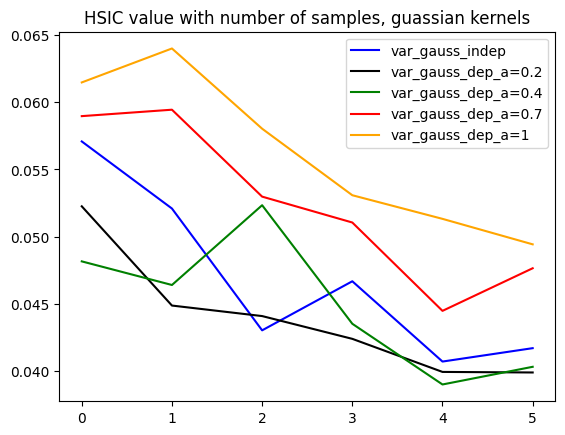

In [12]:
m = 20
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)
start_point = 15
import matplotlib.pyplot as plt
from tqdm import tqdm
a  =0.2
a1 =0.4
a2 =0.7
a3 =1
res_indep = np.empty(m-start_point+1)
res_dep = np.empty(m-start_point+1)
res_dep1 = np.empty(m-start_point+1)
res_dep2 = np.empty(m-start_point+1)
res_dep3 = np.empty(m-start_point+1)
cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0.5,1,0.6,0])

for i in tqdm(range(start_point,m+1)):
    x = X(i,cov,mean)
    y = X(i,cov,mean)
    res_indep[i- start_point] = HSIC(Kf,Kg,x,y)
    x2 = X(i,cov,mean)
    y2 = a*x2 +(1-a)*X(i,cov,mean)
    res_dep[i- start_point]  = HSIC(Kf,Kg,x2,y2)
    x3 = X(i,cov,mean)
    y3 = a1*x3 +(1-a1)*X(i,cov,mean)
    res_dep1[i- start_point] = HSIC(Kf,Kg,x3,y3)
    x4 = X(i,cov,mean)
    y4 = a2*x4 +(1-a2)*X(i,cov,mean)
    res_dep2[i- start_point] = HSIC(Kf,Kg,x4,y4)
    x5 = X(i,cov,mean)
    y5 = a3*x5 +(1-a3)*X(i,cov,mean)
    res_dep3[i- start_point] = HSIC(Kf,Kg,x5,y5)

plt.title("HSIC value with number of samples, guassian kernels")
plt.plot(res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(res_dep,color = "black", label ="var_gauss_dep_a={}".format(a))
plt.plot(res_dep1,color = "green", label ="var_gauss_dep_a={}".format(a1))
plt.plot(res_dep2,color = "red", label ="var_gauss_dep_a={}".format(a2))
plt.plot(res_dep3,color = "orange", label ="var_gauss_dep_a={}".format(a3))
plt.legend()
plt.show()


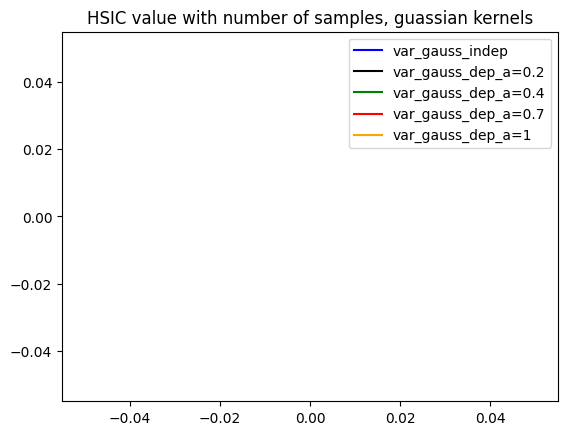

In [13]:
plt.title("HSIC value with number of samples, guassian kernels")
plt.plot(res_indep[50:],color = "blue", label ="var_gauss_indep")
plt.plot(res_dep[50:],color = "black", label ="var_gauss_dep_a={}".format(a))
plt.plot(res_dep1[50:],color = "green", label ="var_gauss_dep_a={}".format(a1))
plt.plot(res_dep2[50:],color = "red", label ="var_gauss_dep_a={}".format(a2))
plt.plot(res_dep3[50:],color = "orange", label ="var_gauss_dep_a={}".format(a3))
plt.legend()
plt.show()

100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


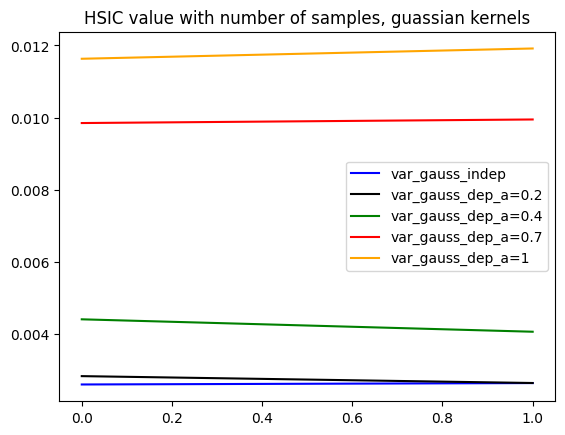

In [14]:
m = 301
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)
start_point = 300
import matplotlib.pyplot as plt
from tqdm import tqdm
a  =0.2
a1 =0.4
a2 =0.7
a3 =1
res_indep = np.empty(m-start_point+1)
res_dep = np.empty(m-start_point+1)
res_dep1 = np.empty(m-start_point+1)
res_dep2 = np.empty(m-start_point+1)
res_dep3 = np.empty(m-start_point+1)
cov = np.identity(4)
cov[1][0] =  0.5
cov[0][1] =  0.5
cov[1][2] =  0.25
cov[2][1] =  0.25
cov[2][3] =  0.75
cov[3][2] =  0.75
mean = np.array([0.5,1,0.6,0])

for i in tqdm(range(start_point,m+1)):
    x = X(i,cov,mean)
    y = X(i,cov,mean)
    res_indep[i- start_point] = HSIC(Kf,Kg,x,y)
    x2 = X(i,cov,mean)
    y2 = a*x2 +(1-a)*X(i,cov,mean)
    res_dep[i- start_point]  = HSIC(Kf,Kg,x2,y2)
    x3 = X(i,cov,mean)
    y3 = a1*x3 +(1-a1)*X(i,cov,mean)
    res_dep1[i- start_point] = HSIC(Kf,Kg,x3,y3)
    x4 = X(i,cov,mean)
    y4 = a2*x4 +(1-a2)*X(i,cov,mean)
    res_dep2[i- start_point] = HSIC(Kf,Kg,x4,y4)
    x5 = X(i,cov,mean)
    y5 = a3*x5 +(1-a3)*X(i,cov,mean)
    res_dep3[i- start_point] = HSIC(Kf,Kg,x5,y5)

plt.title("HSIC value with number of samples, guassian kernels")
plt.plot(res_indep,color = "blue", label ="var_gauss_indep")
plt.plot(res_dep,color = "black", label ="var_gauss_dep_a={}".format(a))
plt.plot(res_dep1,color = "green", label ="var_gauss_dep_a={}".format(a1))
plt.plot(res_dep2,color = "red", label ="var_gauss_dep_a={}".format(a2))
plt.plot(res_dep3,color = "orange", label ="var_gauss_dep_a={}".format(a3))
plt.legend()
plt.show()


### RxR variables


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


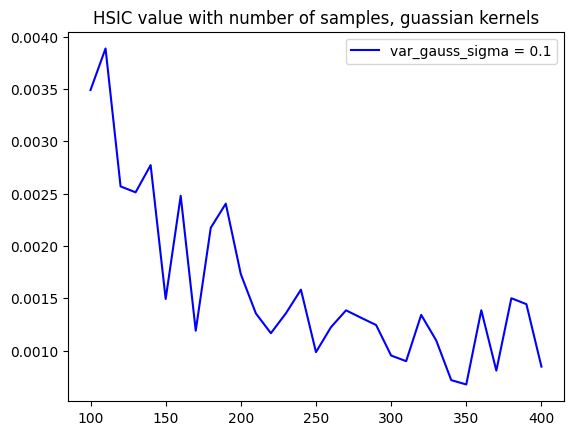

In [15]:
factor = 2
Kf = lambda x,y : K_laplacian(x,y,factor)
Kg = lambda x,y : K_laplacian(x,y,factor)
m = 400
start_point = 100
step= 10
res_indep = np.empty((m-start_point)//step +1)
x_axis = np.array(list(range(start_point,m+1,step)))
gamma = 0.1

for i in tqdm(range(start_point,m+1,step)):
    k = (i-start_point)//step
    x = np.random.normal(0,1,i)
    y = gamma*x + np.sqrt(1- gamma**(2))*np.random.normal(0,1,i)
    res_indep[k] = HSIC(Kf,Kg,x,y)

plt.title("HSIC value with number of samples, guassian kernels")
plt.plot(x_axis,res_indep,color = "blue", label ="var_gauss_sigma = {}".format(gamma))
plt.legend()
plt.show()

In [120]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 1
gamma = 0
gamma_bar = sqrt(1- gamma**2)
X = Normal('X',0,1)
X1 = Normal('X1',0,1)
Z = Normal('Z',0,1)
Z1 = Normal('Z1',0,1)
Y = gamma*X + gamma_bar*Z
Y1 = gamma*X1 + gamma_bar*Z1
W = Normal('W',0,sqrt(2) )  #X-X1
V = Normal('V',0,sqrt(2) )  #Z-Z1
Ex1y1_x2y2 = 1/sqrt(1+8*factor*(1+2*factor*(gamma_bar**2)))
Ex1y1_Ex2y2 = 1/(4*factor+1) 
Ex1y1_Ex2Ey2=1/sqrt( (2*factor+1+2*factor*gamma_bar**2)*(4*factor+1+2*factor*gamma**2)-4*(factor*gamma*gamma_bar)**2)
Ex1y1_x2y2_prime = E(exp(-factor*((1+gamma**2)*W**2 +(gamma_bar*V)**2 +2*gamma*gamma_bar*W*V )))
Ex1y1_Ex2y2_prime = E(exp(-factor*(W)**2))*E(exp(-factor*(V)**2)) 
Ex1y1_Ex2Ey2_prime = E(exp((-factor/(2*factor+1))*((1+gamma**2)*X**2-2*gamma*gamma_bar*Z*X+(gamma_bar*Z)**2)))/(2*factor+1)
print('term1=',N(Ex1y1_x2y2),"term1_prime=",N(Ex1y1_x2y2_prime))
print('term2=',Ex1y1_Ex2y2,"term2_prime=",N(Ex1y1_Ex2y2_prime))
print('term3=',N(Ex1y1_Ex2Ey2),"term3_prime=",N(Ex1y1_Ex2Ey2_prime))
HSIC_pop = Ex1y1_x2y2 + Ex1y1_Ex2y2 - 2*Ex1y1_Ex2Ey2
print("HSIC_pop=",HSIC_pop,"numerical =",N(HSIC_pop))

term1= 0.200000000000000 term1_prime= 0.200000000000000
term2= 0.2 term2_prime= 0.200000000000000
term3= 0.200000000000000 term3_prime= 0.200000000000000
HSIC_pop= 0 numerical = 0


100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


8/15 - 0.308606699924184*sqrt(2)


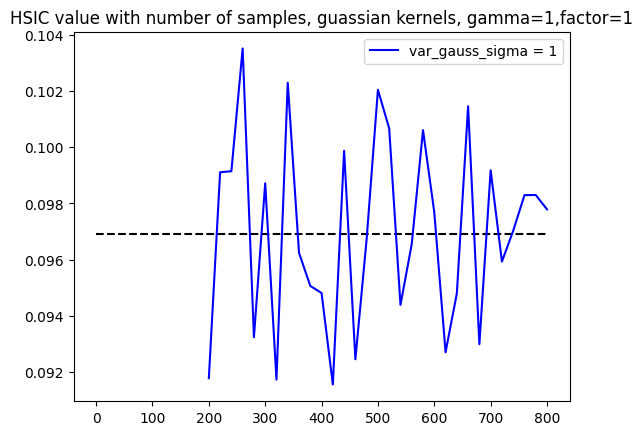

In [115]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)


m = 800
start_point = 200
step= 20
res_indep = np.empty((m-start_point)//step +1)
x_axis = np.array(list(range(start_point,m+1,step)))
gamma = 1
gamma_bar= sqrt(1-gamma**2)


for i in tqdm(range(start_point,m+1,step)):
    k = (i-start_point)//step
    x = np.random.normal(0,1,i)
    y = gamma*x + np.sqrt(1- gamma**(2))*np.random.normal(0,1,i)
    res_indep[k] = HSIC(Kf,Kg,x,y)

X = Normal('X',0,1)
Y = Normal('Y',0,1)
W = Normal('W',0,sqrt(2))
V = Normal('V',0,sqrt(2))

#Ex1y1_x2y2 = 1/sqrt(1+8*factor*(1+2*factor*(gamma_bar**2)))
#Ex1y1_Ex2y2 = 1/(4*factor+1)
#Ex1y1_Ex2Ey2 = 1/sqrt( (2*factor+1+2*factor*gamma_bar**2)*(4*factor+1+2*factor*gamma**2)-4*(factor*gamma*gamma_bar)**2)
Ex1y1_x2y2 = E(exp(-factor*((1+gamma**2)*W**2 +(gamma_bar*V)**2 +2*gamma*gamma_bar*W*V )))
Ex1y1_Ex2y2 = E(exp(-factor*((((W))**2))))*E(exp(-factor*(((V)**2))))
Ex1y1_Ex2Ey2 = E(exp((-factor/(2*factor+1))*((1+gamma**2)*X**2-2*gamma*gamma_bar*Z*X+(gamma_bar*Z)**2)))/(2*factor+1)
HSIC_pop = Ex1y1_x2y2 + Ex1y1_Ex2y2 -2*Ex1y1_Ex2Ey2
print(HSIC_pop)
plt.hlines(HSIC_pop,xmin=0,xmax = x_axis[-1],color = "black",linestyle="--")
plt.title("HSIC value with number of samples, guassian kernels, gamma={},factor={}".format(gamma,factor))
plt.plot(x_axis,res_indep,color = "blue", label ="var_gauss_sigma = {}".format(gamma))
plt.legend()
plt.show()

100%|██████████| 39/39 [01:18<00:00,  2.02s/it]


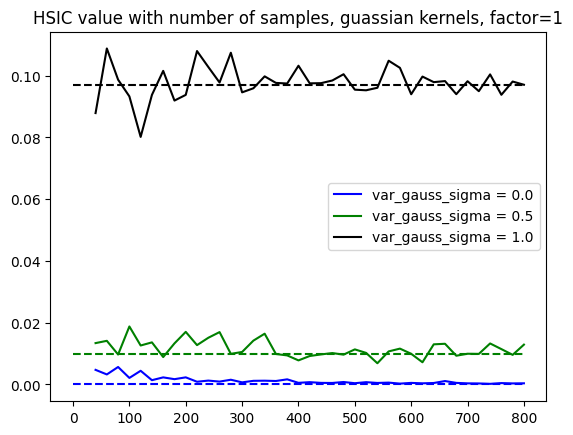

In [126]:
from sympy.stats import Normal,E
from sympy import exp,sqrt,N
factor = 1
Kf = lambda x,y : K_gaussian(x,y,factor)
Kg = lambda x,y : K_gaussian(x,y,factor)


m = 800
start_point = 40
step= 20
gamma = np.array([0,0.5,1])
gamma_bar= np.sqrt(1-gamma**2)
res_gammas = np.empty((len(gamma),(m-start_point)//step +1))
x_axis = np.array(list(range(start_point,m+1,step)))



for j in tqdm(range(start_point,m+1,step)):
    for i in range(len(gamma)):
        k = (j-start_point)//step
        x = np.random.normal(0,1,j)
        y = gamma[i]*x + gamma_bar[i]*np.random.normal(0,1,j)
        res_gammas[i][k] = HSIC(Kf,Kg,x,y)

X = Normal('X',0,1)
Y = Normal('Y',0,1)
W = Normal('W',0,sqrt(2))
V = Normal('V',0,sqrt(2))

colors = ['blue','green',"black"]
for i in range(len(gamma)):
    gamma_i = gamma[i]
    gamma_bar_i = sqrt(1-gamma_i**2)
    Ex1y1_x2y2 = 1/sqrt(1+8*factor*(1+2*factor*(gamma_bar_i**2)))
    Ex1y1_Ex2y2 = 1/(4*factor+1)
    Ex1y1_Ex2Ey2 = 1/sqrt( (2*factor+1+2*factor*gamma_bar_i**2)*(4*factor+1+2*factor*gamma_i**2)-4*(factor*gamma_i*gamma_bar_i)**2)
    HSIC_pop_i = Ex1y1_x2y2 + Ex1y1_Ex2y2 -2*Ex1y1_Ex2Ey2
    plt.hlines(HSIC_pop_i,xmin=0,xmax = x_axis[-1],color = colors[i],linestyles= "--")
    plt.title("HSIC value with number of samples, guassian kernels, factor={}".format(factor))
    plt.plot(x_axis,res_gammas[i],color = colors[i], label ="var_gauss_sigma = {}".format(gamma_i))
plt.legend()
plt.show()

In [95]:
res_indep = np.empty((3,3))
res_indep

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0.,   1.]])